## 读取训练语料和NER结果

In [16]:
import re
import pandas as pd
from tqdm.auto import tqdm

data_path = '/home/cs/yangyuchen/guoyiqiu/kg_llm/data/medmcqa_dev.json'
ner_path = '/home/cs/yangyuchen/guoyiqiu/kg_llm/data/medmcqa_dev_bios_v2.2_release_eng.txt'

data_dir = "/".join(data_path.split('/')[:-1])
print('data_dir: ', data_dir)
data_name = '.'.join(data_path.split('/')[-1].split('.')[:-1]) 
print('data_name: ', data_name)

print(f"读取数据集和NER结果文件...")
with open(ner_path, encoding='utf-8') as f:
    ner_str = f.read()
    f.close()

ner_str = ner_str.replace('｜','|')
with open(ner_path,'w') as f:
    f.write(ner_str)
    f.close()

ner_df = pd.read_csv(ner_path, sep='|')
ner_df['LINE, BEGIN, END'] = ner_df['LINE, BEGIN, END'].apply(lambda x: eval(str(x)))
ner_df['LINE'] = ner_df['LINE, BEGIN, END'].apply(lambda x: x[0])
ner_df['BEGIN, END'] = ner_df['LINE, BEGIN, END'].apply(lambda x: (x[1],x[2]))
ner_df.drop('LINE, BEGIN, END', axis=1, inplace=True)

data_df = pd.read_json(data_path)
data_strs = open(data_path, encoding='utf-8').readlines()
data_df['input_entities'] = data_df.apply(lambda x: [], axis=1)
data_df['input_entities_cid'] = data_df.apply(lambda x: [], axis=1)
data_df['output_entities'] = data_df.apply(lambda x: [], axis=1)
data_df['output_entities_cid'] = data_df.apply(lambda x: [], axis=1)

num_999 = 0
num_not_word = 0
print(f"初步清洗NER结果...")
for row in tqdm(ner_df.itertuples(), total=ner_df.shape[0]):
    j = row.LINE//4
    real_str = data_strs[row.LINE][row[-1][0]:row[-1][1]]
    neighbor_str = data_strs[row.LINE]
    
    if row.STY.startswith('999'):
        num_999+=1
        continue
    if len(re.findall(f"[^\w]{re.escape(real_str)}[^\w]", neighbor_str))==0:
        print('neighbor_str: ', neighbor_str)
        num_not_word+=1
        continue
    if row.LINE%4 == 2:
        data_df.loc[j]['input_entities'].append(real_str)
        data_df.loc[j]['input_entities_cid'].append(row.CID)
    else:
        data_df.loc[j]['output_entities'].append(real_str)
        data_df.loc[j]['output_entities_cid'].append(row.CID)

print(f'被清洗的未知类别(999)实体数量: {num_999}，占比: {num_999/ner_df.shape[0]}')
print(f'被清洗的非单词实体数量: {num_not_word}，占比: {num_not_word/ner_df.shape[0]}')
print('初步清洗后的数据集: ')
data_df

data_dir:  /home/cs/yangyuchen/guoyiqiu/kg_llm/data
data_name:  medmcqa_dev
读取数据集和NER结果文件...
初步清洗NER结果...


  0%|          | 0/26826 [00:00<?, ?it/s]

被清洗的未知类别(999)实体数量: 1544，占比: 0.057556102288824275
被清洗的非单词实体数量: 0，占比: 0.0
初步清洗后的数据集: 


,input,output,input_entities,input_entities_cid,output_entities,output_entities_cid
0,Which of the following is not true for myelina...,A,"[myelinated nerve fibers, Impulse, myelinated ...","[CN33499808, CN00044749, CN02095548, CN0736878...",[],[]
1,Which of the following is not true about glome...,A,"[glomerular capillaries, oncotic pressure, cap...","[CN00453049, CN00007663, CN00015232, CN0045865...",[],[]
2,A 29 yrs old woman with a pregnancy of 17 week...,C,"[pregnancy, down syndrome, down syndrome, advi...","[CN00454003, CN00016551, CN00016551, CN0001799...",[],[]
3,"Axonal transport is: Options:A: Antegrade, B: ...",C,[Axonal transport],[CN00473776],[],[]
4,Low insulin to glucagon ratio is seen in all o...,A,"[insulin, glucagon, Glycogen synthesis, Glycog...","[CN32853719, CN00117640, CN00056666, CN0000965...",[],[]
...,...,...,...,...,...,...
4178,A study is to be conducted with regards to the...,A,"[fat, expressed breast milk, coho]","[CN00506745, CN00150819, CN28173440]",[],[]
4179,"APGAR acronym stands for? Options:A: Activity,...",D,"[APGAR, pulse pressure, grimace, respiration, ...","[CN00033786, CN00029530, CN00086647, CN3292265...",[],[]
4180,Most commonly implicated drug for acute liver ...,A,"[acute liver failure, Paracetamol, Valproate, ...","[CN00452947, CN32931003, CN00236867, CN0005756...",[],[]
4181,A 9 year old boy has steroid dependent nephrot...,B,"[steroid dependent nephrotic syndrome, cushing...","[CN00461839, CN13977028, CN33056928, CN0019686...",[],[]


## 执行TF-IDF清洗

In [17]:
import re
from multiprocessing import Pool, cpu_count
import math
import pickle
from tqdm.auto import tqdm
from collections import defaultdict
import os
import json

os.environ['TOKENIZERS_PARALLELISM'] = 'true'
tqdm.pandas()

corpus = [i.input + " " + i.output for i in data_df.itertuples()]
all_e_list = [i.input_entities + i.output_entities for i in data_df.itertuples()]
all_e =  list(set([e for es in all_e_list for e in es]))
all_text = ' '.join(corpus)


def wc(e):
    return {e:len(re.findall(f"[^\w]{re.escape(e)}[^\w]", all_text))}

if os.path.exists(f'{data_dir}/wc_{data_name}.pkl'):
    print(f"读取缓存的单词计数{data_dir}/wc_{data_name}.pkl...")
    count = pickle.load(open(f'{data_dir}/wc_{data_name}.pkl', 'rb'))
else:
    print("正在进行单词计数...")
    pool = Pool(cpu_count())
    count = {}
    for o in tqdm(pool.imap_unordered(wc, all_e), total=len(all_e)):
        count.update(o)
    pool.close()
    pickle.dump(count, open(f'{data_dir}/wc_{data_name}.pkl', 'wb'))

print("正在计算TF_IDF...")
idf = {e: math.log(len(corpus)/c) for e,c in count.items()}
all_tf = [{e: len(re.findall(f"{re.escape(e)}", corpus[i])) for e in e_list} for i,e_list in enumerate(all_e_list)]
all_tf_idf = [{e: tf[e] * idf[e] for e in tf} for tf in all_tf]

def mean_e_tf_idf(all_tf_idf):
    mean_e_tf_idf = {}
    for tf_idf in all_tf_idf:
        for e in tf_idf:
            if e not in mean_e_tf_idf:
                mean_e_tf_idf[e] = [tf_idf[e]]
            else:
                mean_e_tf_idf[e].append(tf_idf[e])
    for e in mean_e_tf_idf:
        mean_e_tf_idf[e] = sum(mean_e_tf_idf[e]) / len(mean_e_tf_idf[e])

    df = pd.DataFrame(list(mean_e_tf_idf.keys()), columns=['e'])
    df['tf_idf'] = df['e'].apply(lambda x: mean_e_tf_idf[x])
    df.sort_values('tf_idf', ascending=False, inplace=True)
    return df


def wash(row):
    new_input_entities = []
    new_input_entities_cid = []
    new_output_entities = []
    new_output_entities_cid = []
    new_tf_idf = {}
    for e,cid in zip(row['input_entities'],row['input_entities_cid']):
        if row['tf_idf'][e] > TF_IDF_THRESHOLD:
            new_input_entities.append(e)
            new_input_entities_cid.append(cid)
            new_tf_idf[e] = row['tf_idf'][e]
    for e,cid in zip(row['output_entities'],row['output_entities_cid']):
        if row['tf_idf'][e] > TF_IDF_THRESHOLD:
            new_output_entities.append(e)
            new_output_entities_cid.append(cid)
            new_tf_idf[e] = row['tf_idf'][e]
    row['input_entities'] = new_input_entities
    row['input_entities_cid'] = new_input_entities_cid
    row['output_entities'] = new_output_entities
    row['output_entities_cid'] = new_output_entities_cid
    row['tf_idf'] = new_tf_idf
    return row
    
data_df['tf_idf'] = all_tf_idf

TF_IDF_THRESHOLD = 7
print(f"TF_IDF阈值: {TF_IDF_THRESHOLD} 开始执行TF-IDF清洗... ")
new_data_df = data_df.progress_apply(wash, axis=1)
json.dump(new_data_df.to_dict(orient='records'), open(f'{data_dir}/ner_results_{data_name}.json','w'), indent=4)

new_e_tf_idf = mean_e_tf_idf(new_data_df['tf_idf'])
old_e_tf_idf = mean_e_tf_idf(all_tf_idf)
new_e = set(new_e_tf_idf['e'].tolist())
old_e = set(old_e_tf_idf['e'].tolist())
wash_e = old_e - new_e

print(f"清洗了{len(wash_e)}个实体类别")
for e in wash_e:
    print(e)
print("TF-IDF清洗后, 实体总数剩余比例: ", (new_data_df['input_entities'].apply(len).sum()+new_data_df['output_entities'].apply(len).sum()) / (data_df['input_entities'].apply(len).sum() + data_df['output_entities'].apply(len).sum()))
print("TF-IDF清洗后, 实体类别剩余比例:", mean_e_tf_idf(new_data_df['tf_idf'].tolist()).shape[0]/mean_e_tf_idf(all_tf_idf).shape[0])

正在进行单词计数...


  0%|          | 0/14403 [00:00<?, ?it/s]

正在计算TF_IDF...
TF_IDF阈值: 7 开始执行TF-IDF清洗... 


  0%|          | 0/4183 [00:00<?, ?it/s]

清洗了1101个实体类别
Masseter
IgA
EBV
tonsils
Palatine
Pemphigus
Thumb
element
infective endocarditis
Trauma
anemia
Intravenous
abdomen
altered sensorium
lipoproteins
organs
Dexamethasone
skull
Anti D
Diagnosis
maxillary denture
Removal
Acid
screening test
taste
cortex
ESR
ray
Alcohol
thermal conductivity
platelet count
Atropine
dislocation
hepatomegaly
Maxillary lateral incisor
nerves
sodium hypochlorite
stas
occlusal rest
Pulpal
dental caries
Lignocaine
DMT
osteomyelitis
citrate
Hematocrit
Kawasaki disease
Hardness
leg
Vertebral
constrictor
gutta percha
ethanol
barrier
Clindamycin
Lumbar
Calcium gluconate
RBCs
OPD
probable diagnosis
cervical lymphadenopathy
Pneumocystis jirovecii
ulcers
leukoplakia
Needle
Cricoid
mutation
learning
clinical trials
implants
Fibres
aspiration
tolerance
open bite
Mitral regurgitation
exercise
limbs
Spinal cord
soft palate
prothrombin time
infectious
sample size
prothrombin
fascia
laparotomy
Hyperkalemia
Spiral angle
HPV
Fundus
Trochlear nerve
SLE
Calcification
A

## 执行Grounding并导出kg_dataset.json

In [18]:
from collections import defaultdict
import pandas as pd

print("正在读取知识图谱...")
kg = pd.read_csv('data/bios_kg_with_def_detailed.csv')
c2i = defaultdict(list)

print("正在构建知识图谱索引...")
for row in tqdm(kg.itertuples(), total=kg.shape[0]):
    c2i[row[4]].append(row[0])
    
def grounding(row):
    new_input_entities = []
    new_output_entities = []
    new_input_entities_cid = []
    new_output_entities_cid = []
    input_triplets = []
    output_triplets = []
    max_t = 20
    for e,cid in zip(row['input_entities'],row['input_entities_cid']):
        if cid in c2i and len(c2i[cid]) <= max_t:
            new_input_entities.append(e)
            new_input_entities_cid.append(cid)
            input_triplets.append(c2i[cid])
    for e,cid in zip(row['output_entities'],row['output_entities_cid']):
        if cid in c2i and len(c2i[cid]) <= max_t:
            new_output_entities.append(e)
            new_output_entities_cid.append(cid)
            output_triplets.append(c2i[cid])
    row['input_entities'] = new_input_entities
    row['output_entities'] = new_output_entities
    row['input_entities_cid'] = new_input_entities_cid
    row['output_entities_cid'] = new_output_entities_cid
    row['input_triplets'] = input_triplets
    row['output_triplets'] = output_triplets
    return row

print("正在添加知识三元组...")
kg_data_df = new_data_df.progress_apply(grounding, axis=1)
kg_data_df = kg_data_df.drop(['tf_idf','input_entities_cid','output_entities_cid'],axis=1,inplace=False)
import json
json.dump(kg_data_df.to_dict(orient='records'), open(f'{data_dir}/kg_{data_name}.json','w'))
kg_data_df

正在读取知识图谱...
正在构建知识图谱索引...


  0%|          | 0/35327128 [00:00<?, ?it/s]

正在添加知识三元组...


  0%|          | 0/4183 [00:00<?, ?it/s]

,input,output,input_entities,output_entities,input_triplets,output_triplets
0,Which of the following is not true for myelina...,A,"[myelinated nerve fibers, Impulse, myelinated ...",[],"[[390981, 15304396, 15304397], [164317], [1123...",[]
1,Which of the following is not true about glome...,A,"[glomerular capillaries, capillaries, Glucose ...",[],"[[139210], [289441, 25415321], [12229227, 1222...",[]
2,A 29 yrs old woman with a pregnancy of 17 week...,C,"[down syndrome, down syndrome, chromosomal ana...",[],"[[193711, 402105, 3581280, 3581281, 3581282, 3...",[]
3,"Axonal transport is: Options:A: Antegrade, B: ...",C,[Axonal transport],[],"[[68405, 4811405, 4811406]]",[]
4,Low insulin to glucagon ratio is seen in all o...,A,"[Glycogen synthesis, Glycogen breakdown, Gluco...",[],"[[117506, 119873, 221519, 10180219, 10180220],...",[]
...,...,...,...,...,...,...
4178,A study is to be conducted with regards to the...,A,[expressed breast milk],[],"[[10434220, 10434221, 10434222]]",[]
4179,"APGAR acronym stands for? Options:A: Activity,...",D,"[pulse pressure, grimace, respiration, grimace...",[],"[[120027], [110581, 17794761, 17794762, 177947...",[]
4180,Most commonly implicated drug for acute liver ...,A,[],[],[],[]
4181,A 9 year old boy has steroid dependent nephrot...,B,"[subcapsular cataracts, Intravenous immunoglob...",[],"[[21927516], [130868, 24611819, 24611820, 2461...",[]


## 可视化数据集统计信息

平均语料长度:62.92947645230696


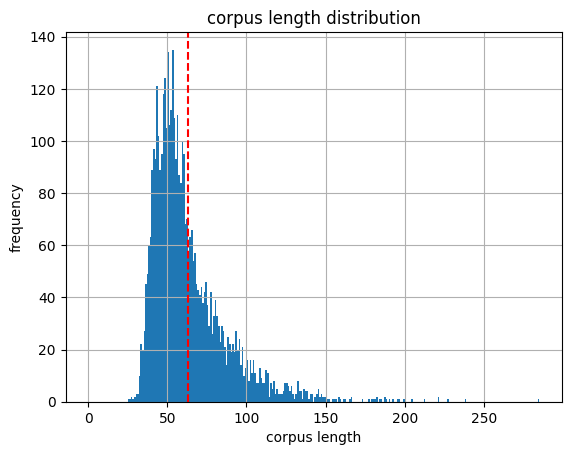

平均每个训练语料的医学实体数量:  3.2493425770977766


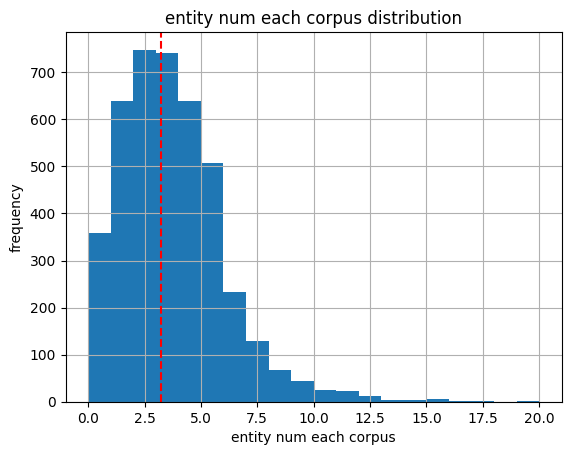

平均每个医学实体的知识三元组数量:  3.9560771041789287


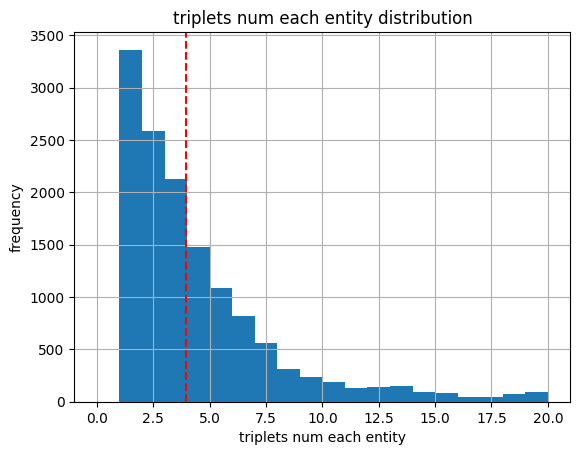

平均每个医学实体的定义知识三元组数量:  1.0218510888758092


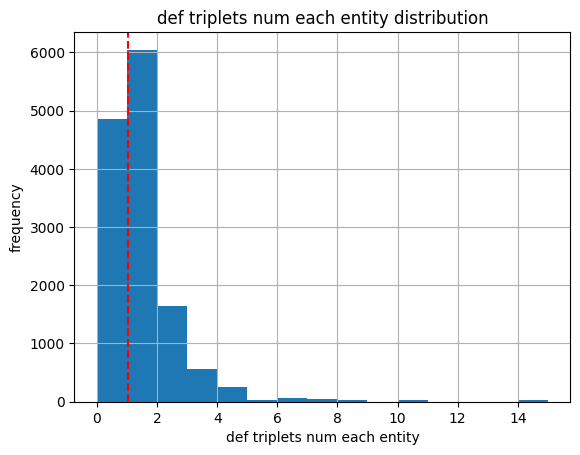

平均每个医学实体的标签知识三元组数量:  2.9342260153031194


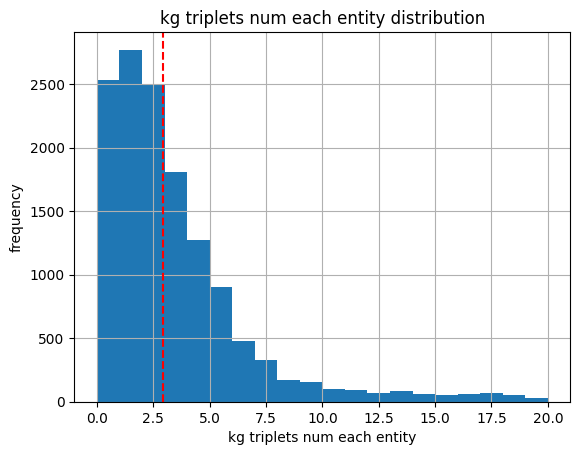

In [19]:
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

tok = AutoTokenizer.from_pretrained("/home/cs/yangyuchen/yushengliao/Medical_LLM/llama-7b-hf")

LEN_DEF = kg[kg['edge'] == "has definition of "].shape[0]

token_num = kg_data_df.apply(lambda x: len(tok(x['input']+x['output'])['input_ids']),axis=1)
token_num.hist(bins=token_num.max(), range=(0, token_num.max()))
print(f'平均语料长度:{token_num.mean()}')
plt.axvline(x=token_num.mean(), color='r', linestyle='--', )
plt.title(f'corpus length distribution')
plt.xlabel('corpus length')
plt.ylabel('frequency')
plt.show()

e_num = kg_data_df.apply(lambda x: len(x['input_entities'])+len(x['output_entities']), axis=1)
print("平均每个训练语料的医学实体数量: ", e_num.mean())
e_num.hist(bins=e_num.max(), range=(0, e_num.max()))
plt.axvline(x=e_num.mean(), color='r', linestyle='--')
plt.title(f'entity num each corpus distribution')
plt.xlabel('entity num each corpus')
plt.ylabel('frequency')
plt.show()


triplets = kg_data_df.apply(lambda x: x['input_triplets']+x['output_triplets'], axis=1).sum()
len_triplets = pd.Series([len(x) for x in triplets])
print("平均每个医学实体的知识三元组数量: ", len_triplets.mean())
len_triplets.hist(bins=len_triplets.max(), range=(0, len_triplets.max()))
plt.axvline(x=len_triplets.mean(), color='r', linestyle='--')
plt.title(f'triplets num each entity distribution')
plt.xlabel('triplets num each entity')
plt.ylabel('frequency')
plt.show()

def_num = pd.Series([len([i for i in x if i < LEN_DEF]) for x in triplets])
print('平均每个医学实体的定义知识三元组数量: ', def_num.mean())
def_num.hist(bins=def_num.max(), range=(0, def_num.max()))
plt.axvline(x=def_num.mean(), color='r', linestyle='--')
plt.title(f'def triplets num each entity distribution')
plt.xlabel('def triplets num each entity')
plt.ylabel('frequency')
plt.show()

tri_num = pd.Series([len([i for i in x if i >= LEN_DEF]) for x in triplets])
print('平均每个医学实体的标签知识三元组数量: ', tri_num.mean())
tri_num.hist(bins=tri_num.max(), range=(0, tri_num.max()))
plt.axvline(x=tri_num.mean(), color='r', linestyle='--')
plt.title(f'kg triplets num each entity distribution')
plt.xlabel('kg triplets num each entity')
plt.ylabel('frequency')
plt.show()

## 生成COT推理数据集

In [20]:
import json
import pandas as pd
import random

COT_INPUT_PROMPT="{INPUT} The medical entities in the text include: {ENTITIES}."
COT_OUTPUT_PROMPT="The related knowledge of the medical entities include: {KNOWLEDGE}\nBased on the medical knowledge, the answer is: {ANSWER}"
SAMPLE_NUM =2 
def cot_refine(row):
    new_row = row.copy()
    ENTITIES = ', '.join(row['input_entities'])
    KNOWLEDGE = ''
    for e,ts in zip(row['input_entities'],row['input_triplets']):
        tss = random.sample(ts,min(SAMPLE_NUM,len(ts)))
        for tid in tss:
            know = kg.iloc[tid]
            KNOWLEDGE += f"{e} {know['edge']} {know['target']}; "
    ANSWER = row['output'].strip()
    new_row['input'] = COT_INPUT_PROMPT.format(INPUT=row['input'], ENTITIES=ENTITIES)
    new_row['output'] = COT_OUTPUT_PROMPT.format(KNOWLEDGE=KNOWLEDGE,ANSWER=ANSWER)
    return new_row

cot_kg_out_data_df = kg_data_df.apply(cot_refine, axis=1)
json.dump(cot_kg_out_data_df.to_dict('records'), open(f'{data_dir}/cot_kg_{data_name}.json','w'), indent=4)
cot_kg_out_data_df

,input,output,input_entities,output_entities,input_triplets,output_triplets
0,Which of the following is not true for myelina...,The related knowledge of the medical entities ...,"[myelinated nerve fibers, Impulse, myelinated ...",[],"[[390981, 15304396, 15304397], [164317], [1123...",[]
1,Which of the following is not true about glome...,The related knowledge of the medical entities ...,"[glomerular capillaries, capillaries, Glucose ...",[],"[[139210], [289441, 25415321], [12229227, 1222...",[]
2,A 29 yrs old woman with a pregnancy of 17 week...,The related knowledge of the medical entities ...,"[down syndrome, down syndrome, chromosomal ana...",[],"[[193711, 402105, 3581280, 3581281, 3581282, 3...",[]
3,"Axonal transport is: Options:A: Antegrade, B: ...",The related knowledge of the medical entities ...,[Axonal transport],[],"[[68405, 4811405, 4811406]]",[]
4,Low insulin to glucagon ratio is seen in all o...,The related knowledge of the medical entities ...,"[Glycogen synthesis, Glycogen breakdown, Gluco...",[],"[[117506, 119873, 221519, 10180219, 10180220],...",[]
...,...,...,...,...,...,...
4178,A study is to be conducted with regards to the...,The related knowledge of the medical entities ...,[expressed breast milk],[],"[[10434220, 10434221, 10434222]]",[]
4179,"APGAR acronym stands for? Options:A: Activity,...",The related knowledge of the medical entities ...,"[pulse pressure, grimace, respiration, grimace...",[],"[[120027], [110581, 17794761, 17794762, 177947...",[]
4180,Most commonly implicated drug for acute liver ...,The related knowledge of the medical entities ...,[],[],[],[]
4181,A 9 year old boy has steroid dependent nephrot...,The related knowledge of the medical entities ...,"[subcapsular cataracts, Intravenous immunoglob...",[],"[[21927516], [130868, 24611819, 24611820, 2461...",[]


## 生成混合triplets数据集

In [26]:
import json
import pandas as pd
import csv
from tqdm.auto import tqdm

data_dir = "data"
data_name = "kg_HealthCareMagic-20k_train"
kg_data_df = pd.DataFrame(json.load(open(f'{data_dir}/{data_name}.json', 'r')))
kg = pd.read_csv('data/bios_kg_with_def.csv')

In [ ]:
all_tri_ids = list(set(kg_data_df.apply(lambda x: [j for i in x['input_triplets'] for j in i] + [j for i in x['output_triplets'] for j in i], axis=1).sum()))
triplets_df = pd.DataFrame([{"input":f"{kg.iloc[tri_id]['source'].strip()} {kg.iloc[tri_id]['edge'].strip()}?", "output":kg.iloc[tri_id]['target'].strip()} for tri_id in all_tri_ids])
data_df_with_tri = pd.concat([kg_data_df.drop(['input_entities','output_entities','input_triplets','output_triplets'], axis=1, inplace=False), triplets_df], axis=0)
json.dump(data_df_with_tri.to_dict(orient='records'),open(f"{data_dir}/tri_{data_name}.json",'w'), indent=4)

def make_triplets(row):
    tri_ids = list(set([j for i in row['input_triplets'] for j in i] + [j for i in row['output_triplets'] for j in i]))
    tri_input = " ".join([f"{kg.iloc[tri_id]['source'].strip()} {kg.iloc[tri_id]['edge'].strip()}?" for tri_id in tri_ids])
    tri_output = ". ".join([f"{kg.iloc[tri_id]['source'].strip()} {kg.iloc[tri_id]['edge'].strip()} {kg.iloc[tri_id]['target'].strip()}" for tri_id in tri_ids])
    return pd.Series({"input": tri_input, "output": tri_output})

triplets_concat_df = kg_data_df.apply(make_triplets, axis=1)
triplets_concat_df = triplets_concat_df[triplets_concat_df['input'].str.len() > 0]
data_df_with_tri_concat = pd.concat([kg_data_df.drop(['input_entities','output_entities','input_triplets','output_triplets'], axis=1, inplace=False), triplets_concat_df], axis=0)
json.dump(data_df_with_tri_concat.to_dict(orient='records'),open(f"{data_dir}/tri_concat_{data_name}.json",'w'), indent=4)